In [2]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
from glob import glob
# Root directory of the project
# ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
from src.config import Config
from src import harz2 as harz
import src.model as modellib
import src.utils as utils

In [18]:
import imp
harz = imp.reload(harz)

In [3]:
class InferenceConfig(harz.HarzConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5
config = InferenceConfig()

In [4]:
model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir='./log')

In [5]:
weights_path = model.find_last()

In [6]:
weights_path

'./log/harz20190226T1127/mask_rcnn_harz_0300.h5'

In [7]:
model.load_weights(weights_path, by_name=True)

Re-starting from epoch 300


In [8]:
images = glob('/notebooks/tmp/data/new_mrcnn_data/validation/x/*.tif')

In [9]:
images

['/notebooks/tmp/data/new_mrcnn_data/validation/x/2912.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/259.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/2889.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/2269.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/2651.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/78.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/1769.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/218.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/1868.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/2025.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/1292.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/2589.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/1282.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/1719.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/2180.tif',
 '/notebooks/tmp/data/new_mrcnn_data/validation/x/443.tif',
 '/notebooks/tmp/data/new_mrc

In [10]:
my_im=images[0]
r = harz.detect_and_color_splash(model, my_im)

Running on /notebooks/tmp/data/new_mrcnn_data/validation/x/2912.tif
Processing 1 images
image                    shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.50483  max:    0.85171  float64
image_metas              shape: (1, 18)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


In [12]:
r.keys()

dict_keys(['class_ids', 'masks', 'scores', 'rois'])

In [13]:
r['class_ids']

array([4, 1, 4, 1, 1, 1, 4], dtype=int32)

In [14]:
out = np.zeros((len(r['scores']),1024,1024))
print(out.shape)
for i in range(len(r['scores'])):
    out[i][r['rois'][i][0]:r['rois'][i][2],r['rois'][i][1]:r['rois'][i][3]] = 1

(7, 1024, 1024)


In [15]:
from src import my_utils as ut

In [14]:
images[0]

'/notebooks/tmp/data/bomb1_meiler2/validation/x/marsly_HG_Dgm05239.tif'

In [16]:
import rasterio

In [17]:
for i in range(out.shape[0]):
    ut.write_numpy_array_to_tif(np.flipud(out[i]), 'w9_ters'+str(i)+'.tif', original_tif=my_im)

In [32]:
dataset_dirX='/notebooks/tmp/data/new_mrcnn_data/validation/x'
dataset_dirY='/notebooks/tmp/data/new_mrcnn_data/validation/ys/masks'
dataset = harz.HarzDataset()
dataset.load_harz(dataset_dirX, dataset_dirY,1024,1024)

In [33]:
dataset.prepare()


In [34]:
import random
image_id = random.choice(dataset.image_ids)


In [57]:
image_id

117

In [43]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

In [41]:
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

image ID: harz.2801.tif (117) /notebooks/tmp/data/new_mrcnn_data/validation/x/2801.tif


In [44]:
image.shape

(256, 256, 1)

In [46]:
image.max()

0.37333184

In [39]:
image = ut.read_tif('/notebooks/tmp/data/new_mrcnn_data/validation/x/2801.tif')

In [128]:
image = (image - image.min()) / (image.max() - image.min())
image = np.expand_dims(image,-1)

In [51]:
results = model.detect([image], verbose=1)


Processing 1 images
image                    shape: (256, 256, 1)         min:    0.21733  max:    0.37333  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.21733  max:    0.37333  float64
image_metas              shape: (1, 18)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -1.41976  max:    2.16878  float32


In [47]:
import matplotlib.pyplot as plt

In [52]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [55]:
import imp
# visualize = imp.reload(visualize)
from src import visualize

In [49]:
from rasterio.plot import show

In [83]:
r_file ='573000_5752000_3hs.tif'
raster = rasterio.open(r_file)

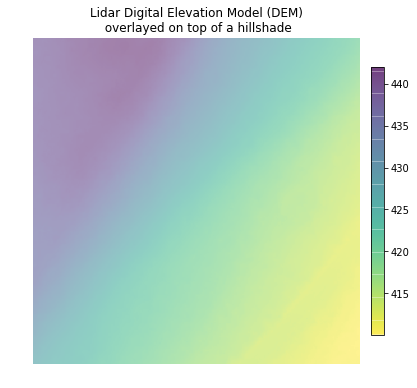

In [53]:
with rasterio.open("/notebooks/tmp/data/new_mask_rcnn_data/bomb1_meiler2x/HG_Dgm05487_7.tif") as lidar_dem:
    lidar_dem_im = lidar_dem.read(1, masked = True)
fig, ax = plt.subplots(figsize = (10,6))
fin_plot = ax.imshow(lidar_dem_im, cmap='viridis_r', alpha=.5)
fig.colorbar(fin_plot, fraction=.024, pad=.02)
ax.set_axis_off()
ax.set(title="Lidar Digital Elevation Model (DEM)\n overlayed on top of a hillshade");

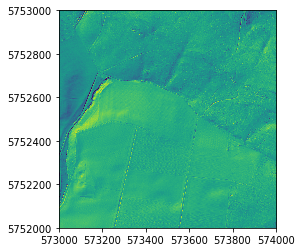

In [84]:
show(raster)

shape:  (256, 256, 1)


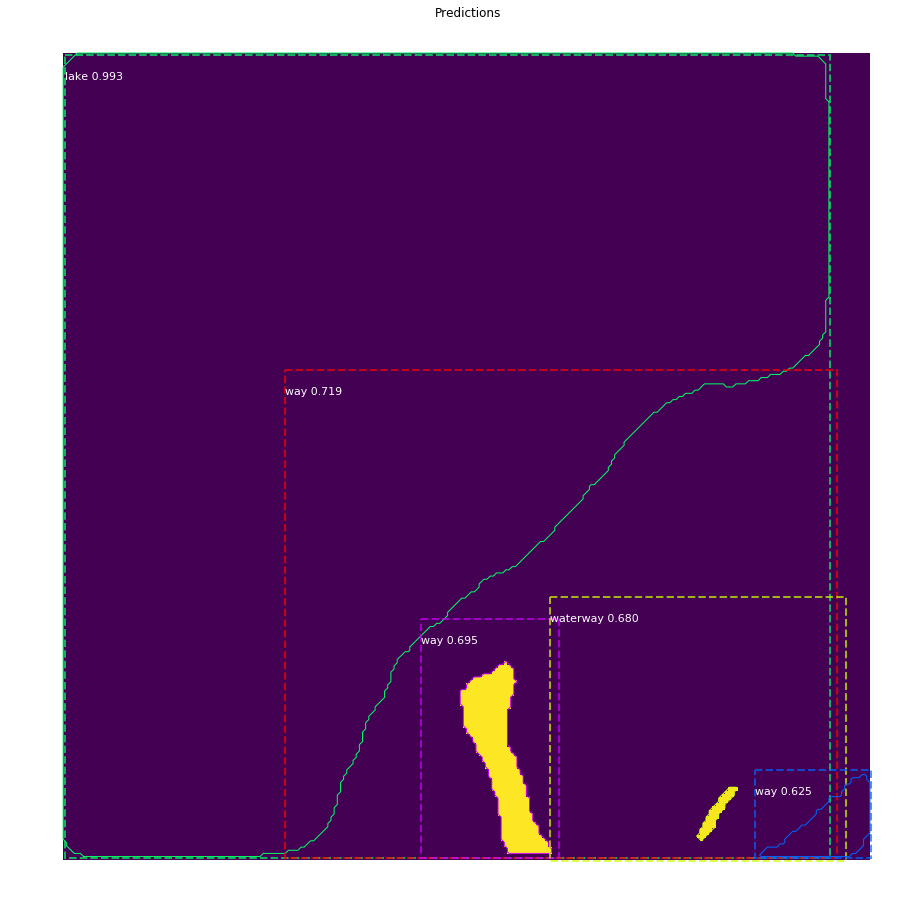

In [56]:
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

In [19]:
r = harz.detect_and_color_splash(model, images[0])

Running on /notebooks/tmp/data/bomb1_meiler2/bomb1_meiler2x_original/marsly_HG_Dgm05280.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 1024, 1024, 1)    min:    0.00000  max:    0.99891  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [46]:
im = '/notebooks/tmp/data/bomb1_meiler2/bomb1_meiler2x_original/marsly_HG_Dgm057.tif'

In [47]:
r2 = harz.detect_and_color_splash(model, im)

Running on /notebooks/tmp/data/bomb1_meiler2/bomb1_meiler2x_original/marsly_HG_Dgm057.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 1024, 1024, 1)    min:    0.00000  max:    0.99717  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


In [48]:
r2.keys()

dict_keys(['rois', 'masks', 'class_ids', 'scores'])

In [27]:
r['rois'][0]

array([114, 115, 140, 141], dtype=int32)

In [28]:
out = np.zeros((len(r['scores']),256,256))
print(out.shape)
for i in range(len(r['scores'])):
    out[i][r['rois'][i][0]:r['rois'][i][2],r['rois'][i][1]:r['rois'][i][3]] = 1


(4, 256, 256)


In [49]:
out2 = np.zeros((len(r2['scores']),256,256))
print(out2.shape)
for i in range(len(r2['scores'])):
    out2[i][r2['rois'][i][0]:r2['rois'][i][2],r2['rois'][i][1]:r2['rois'][i][3]] = 1


(5, 256, 256)


In [29]:
np.unique(out[0],return_counts=True)

(array([0., 1.]), array([64860,   676]))

In [30]:
import src.my_utils as ut

In [22]:
r['rois']

array([[114, 115, 140, 141],
       [ 96,  46, 117,  67],
       [ 66,  78,  85,  97],
       [109,  90, 125, 105]], dtype=int32)

In [50]:
r2['rois']

array([[118, 119, 137, 138],
       [120,  38, 135,  54],
       [135,  46, 153,  65],
       [ 87,  28, 104,  45],
       [206, 197, 221, 213]], dtype=int32)

In [52]:
for i in range(5):
    ut.write_numpy_array_to_tif(out2[i], 'cc'+str(i)+'.tif', original_tif=im)

In [44]:
r['scores']

array([0.99524397, 0.97441554, 0.9380484 , 0.9263757 ], dtype=float32)

In [43]:
r2['scores']

array([0.99524397, 0.97441554, 0.9380484 , 0.9263757 ], dtype=float32)

In [24]:
r['class_ids']

array([2, 2, 2, 2], dtype=int32)

In [23]:
r['masks']

array([[[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       ...,

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False,